# Chapter 5 リカレントニューラルネットワーク（RNN）


In [1]:
'''
1. 確率と言語モデル
1. RNNとは
1. RNNの実装
1. word2vecに関する残りのテーマ
1. まとめ
'''


'\n1. \x08確率と言語モデル\n1. RNNとは\n1. RNNの実装\n\x081. word2vecに関する残りのテーマ\n1. まとめ\n'

# RNNレイヤの実装

In [2]:
import numpy as np

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

# TimeRNNレイヤの実装


In [3]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

# RNNLMの実装


In [4]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


# RNNLMの学習コード


corpus size: 1000, vocabulary size: 418


| epoch 1 | perplexity 393.89


| epoch 2 | perplexity 265.79
| epoch 3 | perplexity 225.83


| epoch 4 | perplexity 217.13


| epoch 5 | perplexity 207.51
| epoch 6 | perplexity 203.16


| epoch 7 | perplexity 199.41


| epoch 8 | perplexity 197.41


| epoch 9 | perplexity 191.27


| epoch 10 | perplexity 192.83
| epoch 11 | perplexity 189.67


| epoch 12 | perplexity 192.38
| epoch 13 | perplexity 189.60
| epoch 14 | perplexity 189.64


| epoch 15 | perplexity 189.69
| epoch 16 | perplexity 186.12
| epoch 17 | perplexity 184.08


| epoch 18 | perplexity 181.91
| epoch 19 | perplexity 183.50
| epoch 20 | perplexity 183.72


| epoch 21 | perplexity 180.59
| epoch 22 | perplexity 180.37
| epoch 23 | perplexity 176.74
| epoch 24 | perplexity 176.75


| epoch 25 | perplexity 175.81
| epoch 26 | perplexity 175.09
| epoch 27 | perplexity 171.05
| epoch 28 | perplexity 169.63


| epoch 29 | perplexity 169.92
| epoch 30 | perplexity 164.84
| epoch 31 | perplexity 163.94
| epoch 32 | perplexity 160.27


| epoch 33 | perplexity 160.27
| epoch 34 | perplexity 155.97
| epoch 35 | perplexity 154.56


| epoch 36 | perplexity 149.53
| epoch 37 | perplexity 143.82
| epoch 38 | perplexity 140.08
| epoch 39 | perplexity 135.38


| epoch 40 | perplexity 132.45
| epoch 41 | perplexity 130.00
| epoch 42 | perplexity 126.68
| epoch 43 | perplexity 118.70


| epoch 44 | perplexity 115.52
| epoch 45 | perplexity 112.77
| epoch 46 | perplexity 108.82


| epoch 47 | perplexity 102.99
| epoch 48 | perplexity 99.17
| epoch 49 | perplexity 96.93


| epoch 50 | perplexity 92.70
| epoch 51 | perplexity 89.17
| epoch 52 | perplexity 83.53
| epoch 53 | perplexity 79.07


| epoch 54 | perplexity 77.68
| epoch 55 | perplexity 73.08
| epoch 56 | perplexity 66.28
| epoch 57 | perplexity 64.94


| epoch 58 | perplexity 61.80
| epoch 59 | perplexity 58.44
| epoch 60 | perplexity 54.23
| epoch 61 | perplexity 52.57


| epoch 62 | perplexity 49.86
| epoch 63 | perplexity 45.82
| epoch 64 | perplexity 43.57
| epoch 65 | perplexity 42.75


| epoch 66 | perplexity 39.41
| epoch 67 | perplexity 37.93
| epoch 68 | perplexity 34.82
| epoch 69 | perplexity 33.39


| epoch 70 | perplexity 31.82
| epoch 71 | perplexity 30.38
| epoch 72 | perplexity 27.24


| epoch 73 | perplexity 25.61
| epoch 74 | perplexity 24.67
| epoch 75 | perplexity 23.53


| epoch 76 | perplexity 22.40
| epoch 77 | perplexity 21.05
| epoch 78 | perplexity 18.97
| epoch 79 | perplexity 17.87


| epoch 80 | perplexity 17.44
| epoch 81 | perplexity 16.86
| epoch 82 | perplexity 15.92
| epoch 83 | perplexity 14.64


| epoch 84 | perplexity 14.38
| epoch 85 | perplexity 13.18
| epoch 86 | perplexity 12.77
| epoch 87 | perplexity 11.96


| epoch 88 | perplexity 11.18
| epoch 89 | perplexity 10.65
| epoch 90 | perplexity 10.45
| epoch 91 | perplexity 10.03


| epoch 92 | perplexity 9.14
| epoch 93 | perplexity 8.68


| epoch 94 | perplexity 8.48
| epoch 95 | perplexity 8.64
| epoch 96 | perplexity 8.02
| epoch 97 | perplexity 7.03


| epoch 98 | perplexity 6.46
| epoch 99 | perplexity 6.34


| epoch 100 | perplexity 6.15


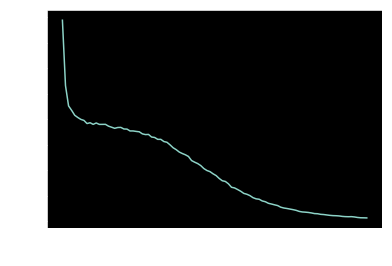

In [5]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()


# RNNLMのTrainerクラス


In [7]:
import time
import matplotlib.pyplot as plt
from common.np import *  # import numpy as np
from common.util import clip_grads


class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # バッチの各サンプルの読み込み開始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # パープレキシティの評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()


def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

